In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.impute import KNNImputer
import pickle
import sys
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error
import shap

sys.path.append("../utils")
from feature_selection import write_features_to_csv, get_features_from_model
from preprocessing import subsets, write_ahi_to_csv, generate_subset_dataset
from modeling import split_data, find_best_data
from threshold_logs import extract_info_folder, extract_log

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

random.seed(0)
np.random.seed(0)

## Import raw data

In [9]:
# read Sleep Heart Health Study Dataset
shhs1 = pd.read_csv(
    "../../data/raw/shhs1-dataset-0.20.0.csv", encoding="cp1252", engine="python"
)
# read Sleep Heart Health Study Dictionary
var_dict = pd.read_csv(
    "../../data/interim/shhs-data-dictionary-0.20.0-variables.csv",
    encoding="cp1252",
    engine="python",
)

## General data processing

In [13]:
# remove sleep monitoring columns from independent variables (unattinable for predicting)
sleep_monitoring_col = var_dict[
    var_dict["folder"].str.contains(r"sleep monitoring", case=False, na=False)
]["id"]
# drop target variables, pptidr (has numerical and categorical values in one column), and sleep monitoring columns in independent variable
x = shhs1.copy().drop(columns=["ahi_c0h4a", "pptidr"])
for col in sleep_monitoring_col:
    if col in x.columns:
        x = x.drop(columns=col)

In [14]:
# normalize x
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

imputer = KNNImputer(n_neighbors=5)  # You can change the number of neighbors if needed
x_imputed_scaled = imputer.fit_transform(x_scaled)

# reverse scaling
x_imputed = scaler.inverse_transform(x_imputed_scaled)

# Convert the result back to DataFrame
x_imputed = pd.DataFrame(x_imputed, columns=x.columns)

# save target hf15 col
hf15 = x_imputed["hf15"]

## Feature Selection to diagnose CSA

In [15]:
# DO NOT CHANGE THIS DICT UNLESS YOU ARE ADDING ANOTHER EXISTING FS METHOD. change selected methods if trying to test a subset of methods
all_methods = {
    "ahi_c0h4a": [
        "decision tree",
        "random forest",
        "mutual information",
        "forward selection AIC",
        "forward selection BIC",
        "backward selection AIC",
    ],
    "hf15": [
        "MRMR 10",
        "MRMR 20",
        "random forest",
        "decision tree",
        "mutual information",
        "forward selection AIC",
        "forward selection BIC",
        "backward selection AIC",
    ],
}

In [16]:
# select from all_methods
selected_methods = {"ahi_c0h4a": all_methods["ahi_c0h4a"], "hf15": all_methods["hf15"]}

In [24]:
# !!!: This block of code on all the feature selection methods (specifically backward selection) will take around 2 hours.
filepath = "../../data/interim/feature_selection/"

# reset x_imputed if hf15 is removed in for loop
x_imputed["hf15"] = hf15

# iterate through chosen methods (out of the available methods) and write important features to a CSV file
for target in ["ahi_c0h4a", "hf15"]:
    y = shhs1[target]
    targets = [target]

    if target == "hf15":
        y = hf15
        x_imputed = x_imputed.drop(columns=["hf15"])

        # if target is heart failure, add nsrrid for preprocessing
        targets.append("nsrrid")

    print("target variable: ", target)
    for method in tqdm(selected_methods[target]):
        print(f"Beginning {method} on target {target}")
        # runs feature selection using the method given and returns either the importances or features (depending on the model)
        model_importances, model_features = get_features_from_model(
            method, x_imputed, y
        )

        # creates a new DataFrame using the important features from the model and writes the new DF to a CSV file in the given file path
        print(
            f"# features selected using {method} on {target}: \
            {write_features_to_csv(x_imputed, shhs1, method, targets, filepath, model_importances, model_features)}"
        )

    print("\n\n")

target variable:  ahi_c0h4a


  0%|          | 0/6 [00:00<?, ?it/s]

Beginning decision tree on target ahi_c0h4a


 17%|█▋        | 1/6 [00:00<00:04,  1.15it/s]

# features selected using decision tree on ahi_c0h4a:             254
Beginning random forest on target ahi_c0h4a


 33%|███▎      | 2/6 [00:30<01:10, 17.51s/it]

# features selected using random forest on ahi_c0h4a:             279
Beginning mutual information on target ahi_c0h4a


 50%|█████     | 3/6 [00:34<00:34, 11.48s/it]

# features selected using mutual information on ahi_c0h4a:             193
Beginning forward selection AIC on target ahi_c0h4a


 67%|██████▋   | 4/6 [01:09<00:41, 20.96s/it]

# features selected using forward selection AIC on ahi_c0h4a:             26
Beginning forward selection BIC on target ahi_c0h4a


 83%|████████▎ | 5/6 [01:16<00:15, 15.73s/it]

# features selected using forward selection BIC on ahi_c0h4a:             9
Beginning backward selection AIC on target ahi_c0h4a


100%|██████████| 6/6 [56:22<00:00, 563.68s/it] 


# features selected using backward selection AIC on ahi_c0h4a:             229



target variable:  hf15


  0%|          | 0/8 [00:00<?, ?it/s]

Beginning MRMR 10 on target hf15


 12%|█▎        | 1/8 [00:03<00:26,  3.84s/it]

# features selected using MRMR 10 on hf15:             10
Beginning MRMR 20 on target hf15


 25%|██▌       | 2/8 [00:07<00:21,  3.55s/it]

# features selected using MRMR 20 on hf15:             20
Beginning random forest on target hf15


 38%|███▊      | 3/8 [00:27<00:56, 11.28s/it]

# features selected using random forest on hf15:             262
Beginning decision tree on target hf15


 50%|█████     | 4/8 [00:28<00:28,  7.05s/it]

# features selected using decision tree on hf15:             94
Beginning mutual information on target hf15


 62%|██████▎   | 5/8 [00:32<00:18,  6.02s/it]

# features selected using mutual information on hf15:             159
Beginning forward selection AIC on target hf15


 75%|███████▌  | 6/8 [01:06<00:31, 15.73s/it]

# features selected using forward selection AIC on hf15:             24
Beginning forward selection BIC on target hf15


 88%|████████▊ | 7/8 [01:22<00:15, 15.72s/it]

# features selected using forward selection BIC on hf15:             13
Beginning backward selection AIC on target hf15


100%|██████████| 8/8 [1:00:51<00:00, 456.48s/it] 

# features selected using backward selection AIC on hf15:             215





##  Cheap feature subset to diagnose CSA

In [27]:
os.makedirs("../../data/processed/cheap_features", exist_ok=True)

In [28]:
cheap_features = [
    "Anthropometry",
    "Clinical Data",
    "Demographics",
    "General Health",
    "Lifestyle and Behavioral Health",
    "Medical History",
    "Sleep Treatment",
]
abbreviations = {
    "Anthropometry": "Ant",
    "Clinical Data": "Cli",
    "Demographics": "Dem",
    "General Health": "Gen",
    "Lifestyle and Behavioral Health": "Lif",
    "Medical History": "Med",
    "Sleep Treatment": "Tre",
}

In [29]:
# make subsets of cheap_features
subsets = subsets(cheap_features)
subsets = [list(subset) for subset in subsets]

In [30]:
cahi = shhs1[["nsrrid", "ahi_c0h4"]]
filepath = "../../data/processed/cheap_features/"

In [31]:
# make a list of datasets with the given features
datasets = []
for subset in subsets:
    generate_subset_dataset(var_dict, subset, shhs1, cahi, abbreviations, filepath)

## Generate different threshold for CSA diagnose

In [32]:
feature_selection_folder = "../../data/interim/feature_selection/"
feature_selection_datasets = os.listdir(feature_selection_folder)

In [33]:
shhs1_4_var = shhs1[["nsrrid", "ahi_c0h4", "ahi_o0h4", "ahi_a0h4"]]
processed_filepath = "../../data/processed/threshold/"
os.makedirs(processed_filepath, exist_ok=True)

In [38]:
# Make different datasets with a dummy variable for each threshold
for dataset in list(
    filter(lambda dataset: "hf15" in dataset, feature_selection_datasets)
):
    hf = pd.read_csv(feature_selection_folder + dataset)

    hf_ahi = pd.merge(hf, shhs1_4_var, on="nsrrid", how="inner")
    hf_ahi = hf_ahi[hf_ahi["hf15"] != 8]

    # Calculates AHI given a range of thresholds and writes them to a CSV file
    for threshold in range(1, 10):
        for threshold_2 in range(1, 5):
            write_ahi_to_csv(
                hf_ahi.copy(), threshold, threshold_2, processed_filepath, dataset
            )

## Models: Finding cheap features subset to predict Central Sleep Apnea

In [39]:
os.makedirs("../../models/cheap_features/", exist_ok=True)
folder_loc = "../../data/processed/cheap_features/"
datasets = os.listdir("../../data/processed/cheap_features/")
target = "ahi_c0h4"

In [41]:
best_mae, best_model, model_name, best_dataset, results = find_best_data(
    folder_loc, datasets, target
)

pickle.dump(
    best_model, open("../../models/cheap_features/" + model_name + ".pkl", "wb")
)

results = pd.read_csv("../../models/cheap_features/all_results.csv")
results["dataset"] = [x.replace("[", "").replace("]", "") for x in results["dataset"]]
results.to_csv("../../models/cheap_features/" + "all_results.csv", index=False)

100%|██████████| 127/127 [19:27<00:00,  9.20s/it]


In [42]:
print(model_name, best_mae)
print(best_model.feature_names_in_)

ridge 4.684644069658723
['gender' 'race' 'mstat' 'hip' 'neck20' 'coffee15' 'tea15' 'soda15'
 'evsmok15' 'smknow15' 'asa15' 'age_s1' 'smokstat_s1' 'ethnicity' 'bmi_s1'
 'educat' 'weight' 'waist' 'height' 'weight20' 'age_category_s1' 'nsrrid']


In [43]:
features_dict = pd.read_csv(
    "../../data/interim/shhs-data-dictionary-0.20.0-variables.csv"
)
# keep only the rows where id == best_model.feature_names_in_
features_dict = features_dict[features_dict["id"].isin(best_model.feature_names_in_)]
features_dict[["display_name", "description", "folder"]].to_csv("./results.csv")

## Hyperparameter tuning of the best cheap feature subset model

In [44]:
# load data and model
best_model = pickle.load(open("../../models/cheap_features/ridge.pkl", "rb"))
df = pd.read_csv("../../data/processed/cheap_features/Ant_Lif.csv")

In [45]:
features = df.columns.tolist()
features.remove(target)
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

In [46]:
# do RandomizedSearchCV to find best hyperparameters
model = Ridge(random_state=1)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

# Split data
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

param_grid = {
    "alpha": uniform(0, 10),
    "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
}

search = RandomizedSearchCV(
    model,
    param_grid,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=5,
    random_state=1,
)
search.fit(X_train, y_train)
print(search.best_params_)
print(search.best_score_)
print(search.best_estimator_)
best_param = search.best_params_

/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/py

{'alpha': 0.923385947687978, 'solver': 'sparse_cg'}
-4.769159928697817
Ridge(alpha=0.923385947687978, random_state=1, solver='sparse_cg')


In [47]:
# test on validation set
model = Ridge(**best_param, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mae_test = mean_absolute_error(y_test, model.predict(X_test))
print(mae)
print(mae_test)

4.7100483689134505
4.666369518021431


In [48]:
# cross validation training
from sklearn.model_selection import cross_val_score

model = Ridge(alpha=best_param["alpha"], solver=best_param["solver"], random_state=1)
scores = cross_val_score(
    model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error"
)
print(scores)
print(scores.mean())

[-4.86010832 -4.89426704 -4.76167671 -4.74352476 -4.58622282]
-4.769159928697817


## Models: Finding feature selection to predict Central Sleep Apnea

In [49]:
datasets = os.listdir("../../data/interim/feature_selection")
datasets = [dataset for dataset in datasets if "ahi_c0h4a" in dataset]

folder_loc = "../../data/interim/feature_selection/"
target = "ahi_c0h4a"

In [53]:
# Save model
best_mae, best_model, model_name, best_dataset, detailed_results = find_best_data(
    folder_loc, datasets, target
)
pickle.dump(
    best_model,
    open("../../models/cheap_features/" + model_name + "_feature_selection.pkl", "wb"),
)

100%|██████████| 6/6 [01:37<00:00, 16.19s/it]


In [54]:
df = pd.read_csv(f"../../data/interim/feature_selection/{best_dataset}")
target = "ahi_c0h4a"

In [55]:
features = df.columns.tolist()
features.remove(target)

# Split data
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

print(features)
print(model_name, best_mae)

['neck20', 'bmi_s1', 'age_s1', 'gender', 'diasbp', 'funres02', 'shhs1_tcvd', 'ess_s1', 'nonsp_st', 'hosnr02', 'benzod1', 'ccb1', 'nsrrid', 'shhs1_qc', 'twuweh02', 'race', 'estrgn1', 'waist', 'soda15', 'tea15', 'urdbpae', 'diuret1', 'pvdl1', 'height', 'weight', 'systbp']
ridge 5.747435889334488


## Threshold analysis

In [56]:
log_folders = os.listdir("../../results/threshold/2023-11-13/")

In [57]:
best_false_negative = 1000
for folder in log_folders:
    f1_test, f1_val, cm = extract_log(
        "../../results/threshold/2023-11-13/" + folder + "/find_threshold.log"
    )

    if f1_test is None:
        continue
    # find the lowest false negative rate
    false_negative = cm[0][1]
    if false_negative < best_false_negative:
        best_false_negative = false_negative
        best_folder = folder
        best_cm = cm
        best_f1_test = f1_test
        best_f1_val = f1_val

extract_info_folder(best_folder)

Dataset: feature_selection_mrmr20
Model: decision_tree
Target: hf15
Threshold CAHI > 2
Threshold CAHI > OAHI * 1/1


## Explanability

In [5]:
dataset = "Ant_Dem_Lif.csv"
folder_loc = "../../data/processed/cheap_features/"
target = "ahi_c0h4"

In [6]:
df = pd.read_csv(folder_loc + dataset)

df.drop(columns=["weight"], inplace=True)

features = df.columns.tolist()
features.remove(target)

# features = best_model.feature_names_in_
# features.remove(target)

# Split data
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

In [12]:
column_rename = {
    "bmi_s1": "Body Mass Index",
    "height": "Height",
    "weight20": "Weight",
    "weight": "Weight",
    "waist": "Waist Circumference",
    "neck20": "Neck Circumference",
    "hip": "Hip Circumference",
    "coffee15": "Coffee Intake",
    "tea15": "Tea Intake",
    "soda15": "Soda Intake",
    "smknow15": "Smoking Status Now",
    "evsmok15": "Smoking Status Ever",
    "smokstat_s1": "Smoking Status",
    "asa15": "Aspirin Intake",
    "gender": "Gender",
    "race": "Race",
    "age_s1": "Age",
    "ethnicity": "Ethnicity",
    "educat": "Education",
    "mstat": "Merital Status",
    "age_category_s1": "Age Category",
}
df = df.rename(columns=column_rename)

In [13]:
# X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)
# rename columns of X_train and X_test
X_train.columns = [
    column_rename.get(n, n) for n in X_train.columns
]  # if n in column_rename.keys()]
X_test.columns = [
    column_rename.get(n, n) for n in X_test.columns
]  # s if n in column_rename.keys()]
model = Ridge(random_state=1, solver="sparse_cg")
model.fit(X_train, y_train)

# create an explainer
explainer = shap.LinearExplainer(model, X_train)
# shap_values_test = explainer.shap_values(X_test)
shap_values_test = explainer(X_test)

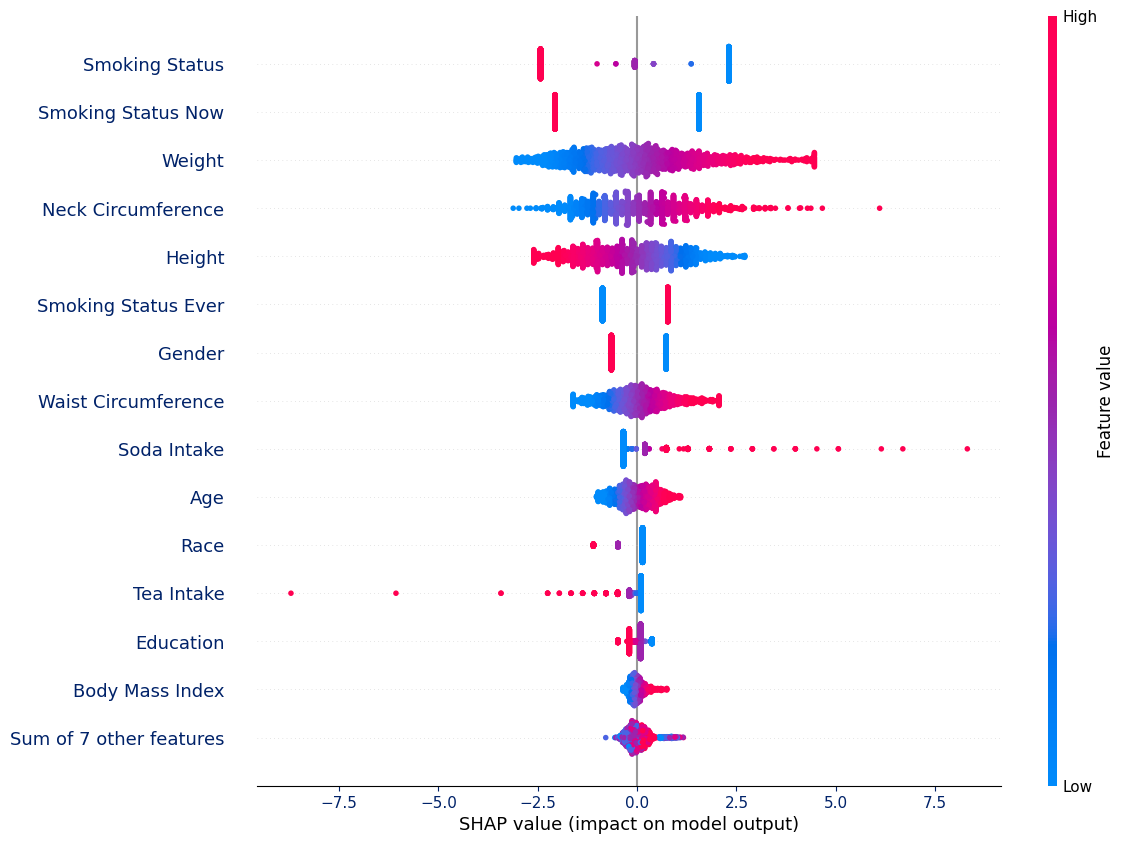

In [14]:
plt.rcParams["figure.figsize"] = [12, 10]

shap.plots.beeswarm(
    shap_values_test,
    max_display=15,
    axis_color="#002269",
    show=False,
    plot_size=(12, 10),
)